In [91]:
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.inspection import PartialDependenceDisplay

plt.style.use("dark_background")

In [78]:
data = pd.read_csv('C:\\Users\\corey\\Desktop\\git\\portfolio\\data_portfolio\\realestate_ml\\data\\houston_houses_engineered.csv', index_col=0)
data['zipTier'] = data['zipTier'].astype('str')
X = data.drop(['price', 'zip'], axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28197 entries, 13656 to 23654
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedrooms      28197 non-null  float64
 1   Sqft.         28197 non-null  float64
 2   lot Sqft.     28197 non-null  float64
 3   full baths    28197 non-null  float64
 4   half baths    28197 non-null  int64  
 5   stories       28197 non-null  float64
 6   Private Pool  28197 non-null  bool   
 7   zipTier       28197 non-null  object 
 8   age           28197 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(1)
memory usage: 2.0+ MB


In [79]:
cat_col = ['zipTier', 'Private Pool']
num_col = ['bedrooms', 'Sqft.', 'lot Sqft.', 'full baths', 'half baths', 'stories', 'age']
num_pipeline = Pipeline([
                ('std_scaler', StandardScaler())
               ])
X_train_nums = num_pipeline.fit_transform(X_train[num_col])

pca = PCA(n_components=7)
pca.fit(X_train_nums)

pca.explained_variance_ratio_

array([0.439986  , 0.16166012, 0.13361651, 0.12271556, 0.06586429,
       0.05249675, 0.02366077])

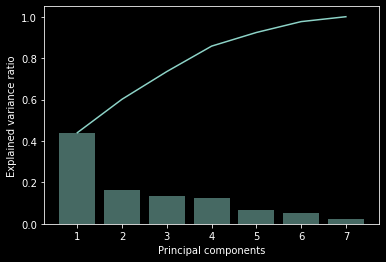

In [80]:
plt.bar(range(1, 8), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.plot(range(1, 8), np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [81]:

def prepareXData(x_data, cat_cols, num_cols, dropFirst=False):
    """
    Accepts: training data and whether or not to drop the first category in OHE
    Returns: prepared data
    """
    num_pipeline = Pipeline([
            ('std_scaler', StandardScaler())
        ])
    cat_pipeline = Pipeline([
        ('OHE_drop_first', OneHotEncoder())
    ])
    cat_pipe_drop_first = Pipeline([
        ('OHE_drop_first', OneHotEncoder(drop='first'))
    ])

    full_pipeline = ColumnTransformer([
            ("num", num_pipeline, num_cols),
            ("cat", cat_pipe_drop_first if dropFirst else cat_pipeline, cat_cols),
        ])
    return full_pipeline
    


In [82]:
cat_cols = ['zipTier', 'Private Pool']
num_cols = ['bedrooms', 'Sqft.', 'lot Sqft.', 'full baths', 'half baths', 'stories', 'age']

l1_pipeline = prepareXData(X_train, dropFirst=True, cat_cols=cat_cols, num_cols=num_cols)
l2_pipeline = prepareXData(X_train, dropFirst=False, cat_cols=cat_cols, num_cols=num_cols)

X_train_prep, X_test_prep = l1_pipeline.fit_transform(X_train), l1_pipeline.transform(X_test)
X_train_prep_dropfirst, X_test_prep_droppfirst = l2_pipeline.fit_transform(X_train), l2_pipeline.transform(X_test)

In [83]:
def evalModel(X, y, model, folds):
    model.fit(X, y)
    score = model.score(X, y)
    scores = cross_val_score(model, X, y, cv=folds)
    mae = mean_squared_error(y, model.predict(X))
    #print(model.score(X, y))
    print(f'Cross validation scores: {scores}')
    print(f'R^2 score: {score}')
    print(f'MAE: {mae}')

In [84]:
lm = LinearRegression()
evalModel(X_train_prep, y_train, lm, 5)

Cross validation scores: [0.49304642 0.51262162 0.55539863 0.52280262 0.37285163]
R^2 score: 0.49749533508123267
MAE: 162572660232.38614


In [ ]:
PartialDependenceDisplay.from_estimator(lm, X_train_prep, ['Sqft.', ('Sqft.', 'price')])

In [85]:
rr = Ridge(alpha=1, fit_intercept=False, solver='auto')
evalModel(X_train_prep_dropfirst, y_train, rr, 5)

Cross validation scores: [0.49313759 0.51262751 0.55534394 0.52277726 0.37287693]
R^2 score: 0.49749492586763233
MAE: 162572792623.0847


In [86]:
lasso = Lasso(alpha=75.0, max_iter=3000, selection='random')
evalModel(X_train_prep_dropfirst, y_train, lasso, 5)

Cross validation scores: [0.49333795 0.51258829 0.55520789 0.52269719 0.3729431 ]
R^2 score: 0.4974898060740939
MAE: 162574449002.6439


In [87]:
forest = RandomForestRegressor(n_estimators=100,
                                max_depth=None,
                                bootstrap=True,
                                n_jobs=1, 
                                random_state=42)

evalModel(X_train_prep, y_train, forest, 5)                                

Cross validation scores: [0.57105572 0.40679566 0.59902113 0.61816989 0.440697  ]
R^2 score: 0.9269973475963007
MAE: 23618159658.693226


In [88]:
forest_gb = GradientBoostingRegressor(loss='squared_error',
                                   learning_rate=0.1,
                                   n_estimators=500,
                                   criterion='friedman_mse',
                                   max_depth=3,
                                   random_state=42)

evalModel(X_train_prep_dropfirst, y_train, forest_gb, 5)  

Cross validation scores: [0.54363636 0.50978089 0.61689979 0.68333904 0.45797037]
R^2 score: 0.8041792659094864
MAE: 63352840067.4645


In [89]:


svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

evalModel(X_train_prep_dropfirst, y_train, svr_rbf, 5)
evalModel(X_train_prep_dropfirst, y_train, svr_lin, 5)
evalModel(X_train_prep_dropfirst, y_train, svr_poly, 5)

Cross validation scores: [0.06490191 0.04547359 0.02849264 0.05467103 0.02794127]
R^2 score: 0.05165385276180978
MAE: 306813382523.6628
Cross validation scores: [0.36356253 0.34835266 0.32567318 0.35828266 0.24812132]
R^2 score: 0.3297788381202036
MAE: 216833086014.14307
Cross validation scores: [0.27476465 0.4556893  0.61211974 0.45595182 0.29315802]
R^2 score: 0.47210972353182634
MAE: 170785532050.95947


In [90]:
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

evalModel(X_train_prep, y_train, svr_rbf, 5)
evalModel(X_train_prep, y_train, svr_lin, 5)
evalModel(X_train_prep, y_train, svr_poly, 5)

Cross validation scores: [0.06375494 0.04471388 0.02809979 0.05362622 0.02712159]
R^2 score: 0.05099457156981446
MAE: 307026676259.43567
Cross validation scores: [0.35597355 0.34157476 0.32000971 0.34943113 0.24313809]
R^2 score: 0.32304429033011983
MAE: 219011878423.70813
Cross validation scores: [0.19065511 0.46597089 0.59550054 0.46538423 0.28527279]
R^2 score: 0.4764877393848328
MAE: 169369135879.03958
